Inspection of the entire CMC Human clinical data set and its subset that is relevant to our BSM study.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import synapseclient
import fwsel

## Data set
### Import and general properties

In [2]:
syn = synapseclient.login()
wdir = '/big/results/bsm/2020-08-05-cmc-clinical'
cmc_clinical_syn = syn.get('syn2279441', downloadLocation=wdir, ifcollision='overwrite.local')
cmc_clinical = pd.read_csv(cmc_clinical_syn.path, index_col='Individual ID')

Welcome, Attila Jones!



In [3]:
samples = pd.read_csv('/big/results/bsm/2020-05-18-processed-samples/all_samples.csv')
individuals = list(set(samples['Individual ID']))
individuals.sort()
print(len(samples), 'samples from', len(individuals), 'individuals')

116 samples from 95 individuals


In [4]:
clin = cmc_clinical.loc[individuals, :]
clin.to_csv(wdir + '/all_samples_clinical.csv')

### Variables with missing values

In [5]:
l = list()
for col in clin.columns:
    missing = len(clin) - len(clin[col].dropna())
    s = pd.Series([missing], index=[col])
    l.append(s)

ss = pd.concat(l).sort_values()
ss.loc[ss != 0]

Brain Weight (in grams)                   1
CDR                                      20
pH                                       22
H/O Stroke                               28
H/O COPD                                 28
H/O Head Inj.                            28
Lobotomy                                 28
Braak Stage                              28
H/O PD.AD.LBD.Pick                       28
Seizures                                 28
Weight (kg)                              39
Weight (pounds)                          39
BMI (Traditional)                        46
BMI (cm/kg)                              46
Height (cm)                              46
Height (Inches)                          46
Antipsychotic-Free (weeks)               50
DescDeath                                69
Presence or Absence of Dementia (Y/N)    75
SCZ Pair                                 76
Tobacco (Past)                           91
Changed (used Affy phenotype)            92
Individual Notes                

Impute the missing observation for Brain Weight with the sample mean 

In [6]:
clin.loc[np.isnan(clin['Brain Weight (in grams)']), 'Brain Weight (in grams)'] = clin['Brain Weight (in grams)'].mean()

### Filtering I

Now remove all columns with missing data

In [7]:
clin = clin.dropna(axis=1)
clin.columns

Index(['Institution', 'Reported Gender', 'Sex', 'Ethnicity', 'ageOfDeath',
       'Brain Weight (in grams)', 'PMI (in hours)', 'Dx', 'Year of Autopsy',
       'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp',
       'Antidepress', 'Lithium', 'Tobacco', 'Alcohol', 'Illicitsub',
       'causeOfDeath', 'Hyperten', 'DiabetesInsDep', 'DiabetesNonInsDep'],
      dtype='object')

Inspect data types for remaining columns

In [8]:
clin = clin.rename(columns={'PMI (in hours)': 'PMI', 'Year of Autopsy': 'YearOfAutopsy', 'Reported Gender': 'ReportedGender', 'Brain Weight (in grams)': 'BrainWeight'})
clin.dtypes

Institution           object
ReportedGender        object
Sex                   object
Ethnicity             object
ageOfDeath           float64
BrainWeight          float64
PMI                  float64
Dx                    object
YearOfAutopsy        float64
Benzodiazepines      float64
Anticonvulsants      float64
AntipsychTyp         float64
AntipsychAtyp        float64
Antidepress          float64
Lithium              float64
Tobacco              float64
Alcohol              float64
Illicitsub           float64
causeOfDeath         float64
Hyperten             float64
DiabetesInsDep       float64
DiabetesNonInsDep    float64
dtype: object

Adjust data types

In [9]:
l = [clin.loc[:, :'Ethnicity'].astype('category'),
pd.DataFrame({'Dx': [np.int(y == 'SCZ') for y in clin['Dx']]}, index=clin.index),
clin.loc[:, 'Benzodiazepines':].astype('int').astype('category')]
clin = pd.concat(l, axis=1)

### Filtering II

It turned out from an email communication with Jessica Johnson that there are missing data labeled with `-1`.  Let's filter the data according to this! 

In [10]:
for col in clin.loc[:, 'Benzodiazepines':].columns:
    s = clin.groupby(col).size()
    if -1 in set(s.index):
        print(s.loc[-1], 'missing in', col)

31 missing in Tobacco
1 missing in Alcohol
1 missing in causeOfDeath
10 missing in Hyperten
10 missing in DiabetesInsDep
10 missing in DiabetesNonInsDep


Since only one point is missing for both Alcohol and causeOfDeath, these variables are imputed and kept.  The rest are dropped.

In [11]:
clin = clin.drop(columns=['Tobacco', 'Hyperten', 'DiabetesInsDep', 'DiabetesNonInsDep'])

Impute Alcohol and causeOfDeath

In [12]:
def replaceWithMode(col='Alcohol', clin=clin):
    '''Returns the mode i.e the most frequent category'''
    df = clin.groupby(col).size()
    d = dict(zip(list(df), df.index))
    mode = d[df.max()]
    s = clin[col]
    s = pd.Series([(lambda y: mode if y == -1 else y)(x) for x in s], index=clin.index, dtype='category')
    return(s)

clin['Alcohol'] = replaceWithMode(col='Alcohol')
clin['causeOfDeath'] = replaceWithMode(col='causeOfDeath')

### Further filtering to avoid colinearity

In [13]:
clin.columns

Index(['Institution', 'ReportedGender', 'Sex', 'Ethnicity', 'Dx',
       'Benzodiazepines', 'Anticonvulsants', 'AntipsychTyp', 'AntipsychAtyp',
       'Antidepress', 'Lithium', 'Alcohol', 'Illicitsub', 'causeOfDeath'],
      dtype='object')

#### ReportedGender and Sex

One of the individuals was a schizophrenic male with Klinefelter syndrome.

In [14]:
clin.groupby(['ReportedGender', 'Sex', 'Dx']).size()

ReportedGender  Sex  Dx
Female          XX   0      9
                     1     25
                XXY  0      0
                     1      0
                XY   0      0
                     1      0
Male            XX   0      0
                     1      0
                XXY  0      0
                     1      1
                XY   0     19
                     1     41
dtype: int64

In [15]:
clin.loc[clin['Sex'] == 'XXY', ['ReportedGender', 'Sex']]

,ReportedGender,Sex
Individual ID,,
CMC_MSSM_213,Male,XXY


Note that there are no transgender individuals with canonical XX or XY chromosomes. It is simpler to keep ReportedGender and drop Sex because the latter is a three level factor whose third level, XXY, occurs only in one individual.

In [16]:
clin = clin.drop(columns='Sex') # this is essentially the same as "Sex" 

## The cleaned data set

In [17]:
clin

,Institution,ReportedGender,Ethnicity,Dx,Benzodiazepines,Anticonvulsants,AntipsychTyp,AntipsychAtyp,Antidepress,Lithium,Alcohol,Illicitsub,causeOfDeath
Individual ID,,,,,,,,,,,,,
CMC_MSSM_027,MSSM,Male,Caucasian,1,0,0,0,0,0,0,1,0,1
CMC_MSSM_033,MSSM,Female,African-American,0,0,0,0,0,0,0,0,0,1
CMC_MSSM_055,MSSM,Male,Caucasian,0,0,0,0,0,0,0,0,0,1
CMC_MSSM_056,MSSM,Female,Caucasian,0,0,0,0,0,0,0,0,0,1
CMC_MSSM_063,MSSM,Male,Caucasian,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CMC_PITT_098,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,0,1
CMC_PITT_101,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,0,1
CMC_PITT_113,Pitt,Male,Caucasian,0,0,0,0,0,0,0,0,0,1


## Modeling
### Forward selection

I used [this implementation](https://planspace.org/20150423-forward_selection_with_statsmodels/) of forward variable selection.  In this implementation the adjusted R-squared statistic was the score that was maximized as the algorithm progressed. 

In [18]:
best = fwsel.forward_selected(clin, 'Dx')

The results below show that typical and atypical antipsychotics have the most significant "effect" on schizophrenia 

In [19]:
best.model.formula

'Dx ~ AntipsychAtyp + Alcohol + AntipsychTyp + Ethnicity + Institution + Benzodiazepines + ReportedGender + Antidepress + 1'

In [20]:
best.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Dx   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     7.740
Date:                Fri, 07 Aug 2020   Prob (F-statistic):           3.12e-08
Time:                        00:36:30   Log-Likelihood:                -31.750
No. Observations:                  95   AIC:                             83.50
Df Residuals:                      85   BIC:                             109.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.6811      0.112      6.057      0.000       0.457       0.905
AntipsychAtyp[T.1]         0.4244      0.083      5.139      0.000       0.260       0.589
Alcohol[T.1]               0.3441      0.098      3.498      0.001       0.149       0.540
AntipsychTyp[T.1]          0.3996      0.103      3.876      0.000       0.195       0.605
Ethnicity[T.Caucasian]    -0.0572      0.105     -0.542      0.589      -0.267       0.153
Ethnicity[T.Hispanic]     -0.8126      0.277     -2.935      0.004      -1.363      -0.262
Institution[T.Pitt]       -0.1691      0.098     -1.721      0.089      -0.365       0.026
Benzodiazepines[T.1]      -0.1259      0.113     -1.112      0.269      -0.351       0.099
ReportedGender[T.Male]    -0.1502      0.085     -1.771      0.080      -0.319       0.018
Antidepress[T.1]          -0.1612      0.105     -1.531      0.129      -0.371       0.048
==============================================================================
Omnibus:                        5.663   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.059   Jarque-Bera (JB):                3.353
Skew:                          -0.262   Prob(JB):                        0.187
Kurtosis:                       2.244   Cond. No.                         12.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Antipsychotics

The following summary shows that out of 67 schizophrenic individuals 28 did not take any antipsychotics.

In [21]:
clin.groupby(['Dx', 'AntipsychTyp', 'AntipsychAtyp']).size()

Dx  AntipsychTyp  AntipsychAtyp
0   0             0                26
                  1                 2
    1             0                 0
                  1                 0
1   0             0                28
                  1                22
    1             0                11
                  1                 6
dtype: int64

### Fit diagnostics

Atypical antipsychothics `AntipsychAtyp` had the most significant effect on disease status `Dx`.  Below are regression plots for this variable that show residuals as well as regression coefficients (slopes of solid straight lines in lower plots).

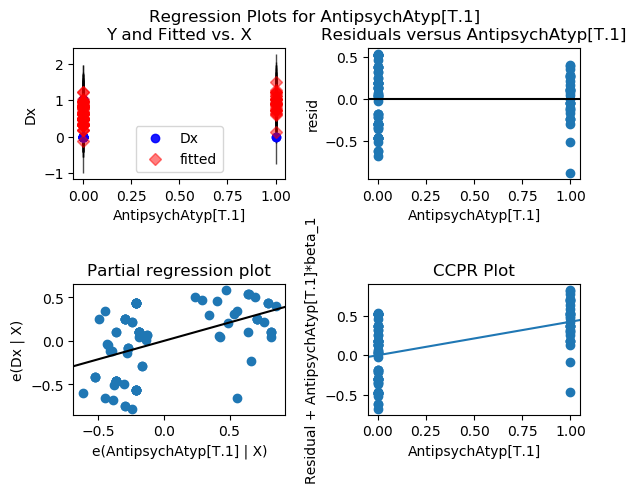

In [22]:
%matplotlib tk
sm.graphics.plot_regress_exog(best, 'AntipsychAtyp[T.1]')

## Conclusions

* Much of the CMC clinical data is missing.  Filtering removed most variables leaving 13, two of which had one missing value each, which were imputed using the sample mean and mode, respectively
* Reported Gender and Sex are nearly identical.  Sex is a three level factor: XX, XY and XXY. The third level, XXY, occurs in only one individual, a schizophrenic male with Klinefelter syndrome.  To avoid colinearity between these two variables one of them needs to be removed.  Removing Sex leaves the simpler (two level) Reported Gender in the data set.
* The remaining 12 variables were split to 1 response (`Dx`) and 11 explanatory variables.  8/11 explanatory variables were selected with a forward strategy using normal linear models and adjusted R-squared as score.
* Among the 8 selected explanatory variables only AntipsychAtyp, AntipsychAtyp, Alcohol and Ethinicity had significant ($p \le 0.01$) "effect" on disease status.  Not quite significant effects were displayed by Institution and Gender.
* AntipsychAtyp, AntipsychAtyp, Alcohol might be assumed to be an *a posteriori* conditions relative to the onset of schizophrenia.  That assumption means they do not carry risk for schizophrenia.  On the other hand, Ethinicity is clearly an *a priori* condition and as the regression coefficient's t-statistic suggests being African American carries risk relative to Hispanic individuals.
* Thus *a posteriori* explanatory variables may or may not be included in further analyses. 
    * If they *are* included they improve fit
    * If they are *not* included they might confound inference.  Despite that excluding all clinical variables (except individual ID) is beneficial because ordinary least squares (OLS) can be used instead of generalized ones (GLS).

In [23]:
%connect_info

{
  "shell_port": 49841,
  "iopub_port": 47355,
  "stdin_port": 43323,
  "control_port": 48497,
  "hb_port": 53249,
  "ip": "127.0.0.1",
  "key": "4ecdfb60-34c003ab2982347f21854f03",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9d1ae2b5-1e63-4d16-92b6-22d7598b79e5.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
